# Setup

## Get general data & imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import re
import pandas as pd
import unicodedata
from IPython.display import SVG


# Get general data

df_raw = pd.read_csv("MESAS_ESCRUTADAS_Cierre.csv", sep=',')
df_diputados = df_raw.loc[df_raw["Cargo"] == "DIPUTADOS NACIONALES"] # Filter for only diputados

# Clean district names
def stripAccents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

districts_raw = df_diputados["Distrito"].unique()
districts = []
for district in districts_raw:
    
    # Replace space with underscore
    district_clean = district.replace(" ", "_")
    
    # Replace accented characters
    district_clean = stripAccents(district_clean)
    
    # Replace district names with clean names: Entre Ríos --> Entre_Rios
    df_diputados = df_diputados.replace(district, district_clean)
    
    
    districts.append(district_clean)
    
# Remove nan 
df = df_diputados[~df_diputados["Agrupacion"].isnull()]   
    
# Create pandas with votes per party per district
country_dict = {}
for district in districts:
    df_district = df.loc[df["Distrito"] == district]
    parties_district = df_district["Agrupacion"].unique()
    dict_district = {}
    
    for party in parties_district:
        n_votes = df_district.loc[df_district["Agrupacion"]== party]["votos"].sum()
        dict_district[party] = n_votes
        
    country_dict[district] = dict_district

df_votes_tot = pd.DataFrame(country_dict)
df_votes_tot = df_votes_tot.fillna(0)

# Get general data
parties = df["Agrupacion"].unique().tolist()
n_votes_total = df["votos"].sum()

## Functions

In [3]:
# Create mapping to [0, 254]
def createDiscreteLinearMapping(input_min, input_max, output_min, output_max):
    k = (output_max - output_min)/(input_max - input_min)
    m = output_max - input_max * k   
    return lambda x: int(x*k + m)

# Append 'linear' column to dataframe
def appendLinearValues(df, column_name):
    val_max = df[column_name].max()
    val_min = df[column_name].min()
    mapping = createDiscreteLinearMapping(val_min, val_max, 0, 254)
    df_result = df.copy()
    df_result["linear"] = df[column_name].apply(mapping)
    return df_result


# Create dictionary with min, mid and max values of column
def createMinMaxDict(df, column_name):
    val_max = df[column_name].max()
    val_min = df[column_name].min()
    val_mid = (val_max + val_min)/2
    dict_percent = { "val_min": val_min, "val_mid": val_mid, "val_max": val_max}
    return dict_percent


# Create a list of colors
def createColorList(color_map_name, n_values):
    cmap = plt.get_cmap(color_map_name, n_values)  
    color_list = []
    for i in range(cmap.N):
        rgba = cmap(i)
        hex_color = matplotlib.colors.rgb2hex(rgba)[1:]
        color_list.append(hex_color)
    return color_list

# Append color column to dateframe
def appendHexColors(df, column_name, color_map_name):
    
    val_min =  df[column_name].min()
    val_max = df[column_name].max()
    n_values = val_max - val_min + 1
    color_list = createColorList(color_map_name, n_values)
    df_result = df.copy()
    df_result["color_hex"] = df[column_name].apply(lambda x: color_list[int(x - val_min)])
    
    return df_result



# Create svg gradient
def createSvgGradient(color_map_name = 'RdPu'):
    cmap = plt.get_cmap(color_map_name, 255)
    text_list = []
    for i in reversed(range(cmap.N)):
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba
        percentage = 100 - i/255 * 100
        hex_color = matplotlib.colors.rgb2hex(rgba)
        text_row = f"""<stop offset="{percentage}%" stop-color="{hex_color}"/>"""

        text_list.append(text_row)

    gradient_text = """
    {}
    """.format("\n".join(text_list))
    
    return gradient_text

# Create new svg from template file
def createFileSvgProvinces(df, dict_min_max, color_map_name, output_file):
    with open("images/argentina_provinces_template.svg", 'r') as f_template:

        text = f_template.read()
        # Fill provinces
        for idx, row in df.iterrows():
            district = row.name
            color_hex = row.color_hex
            template_val = f"\\{{{district}\\}}"
            text = re.sub(template_val, color_hex, text)

        # Insert min, mid and max values in bar
        for key, value in dict_min_max.items():
            template_val = f"\\{{{key}\\}}"
            value_text = f"{value*100:.0f}"
            text = re.sub(template_val, value_text, text)

        # Fix color bar colors
        text_gradient = createSvgGradient(color_map_name)
        text = re.sub("{gradient}", text_gradient, text)


        with open(f'images/{output_file}.svg', 'w') as f_output:
            f_output.write(text)
            
            
            
def createFileSvgDiscrete(df, text_discrete, color_map_name, output_file):
    with open("images/argentina_provinces_template_nobar.svg", 'r') as f_template:

        text = f_template.read()
        # Fill provinces
        for idx, row in df.iterrows():
            district = row.name
            color_hex = row.color_hex
            template_val = f"\\{{{district}\\}}"
            text = re.sub(template_val, color_hex, text)

        # Insert discrete color bar
        text_gradient = createSvgGradient(color_map_name)
        text = re.sub("{discrete_bar}", text_discrete , text)


        with open(f'images/{output_file}.svg', 'w') as f_output:
            f_output.write(text)
            
def createSvgDiscrete(x_bottom, y_bottom, width, height, color_map_name, label_min, label_max, text_color):

    n_squares = label_max - label_min + 1
    text_list = []
    cmap = plt.get_cmap(color_map_name, n_squares)
    text_list = []
    for i in range(cmap.N):
        rgba = cmap(i)
        hex_color = matplotlib.colors.rgb2hex(rgba)

        y = y_bottom - height * i


        text_row = f"""<rect x="{x_bottom}" y="{y}" width="{width}" height="{height}" fill="{hex_color}"/>"""

        text_list.append(text_row)

    text_squares = """
    {}
    """.format("\n".join(text_list))
    
   
    # Create text
    x_text = x_bottom + width/2
    y_text_top =  y_bottom - n_squares * height + 2 * height
    y_text_bottom = y_bottom + height
    text_width = width/2
    text_height = height

    text_labels = f"""<text x="{x_text}" y="{y_text_bottom}" width="{text_width}" height="{text_height}" text-anchor="middle" font-size="2em" fill="{text_color}">
    {label_min}
    </text>
    <text x="{x_text}" y="{y_text_top}" width="{text_width}" height="{text_height}" text-anchor="middle" font-size="2em" fill="{text_color}">
    {label_max}
    </text>"""

    text_result = text_squares + "/n" + text_labels
    
    return text_result

## Showcase

In [2]:
df_votes_tot

,Cordoba,Corrientes,Salta,Santa_Cruz,Chaco,Entre_Rios,Misiones,Santa_Fe,Ciudad_Autonoma_de_Buenos_Aires,San_Juan,...,Rio_Negro,"Tierra_del_Fuego,_Antartida_e_Islas_del_Atlantico_Sur",Jujuy,Mendoza,Chubut,La_Rioja,San_Luis,Catamarca,Santiago_del_Estero,Formosa
JUNTOS POR EL CAMBIO,1059399.0,0.0,0.0,0.0,0.0,0.0,0.0,724008.0,855562.0,171923.0,...,100955.0,0.0,0.0,0.0,0.0,0.0,0.0,74709.0,0.0,0.0
HACEMOS POR CÓRDOBA,490235.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRENTE DE TODOS,205581.0,197395.0,200730.0,45292.0,263929.0,250895.0,95441.0,563323.0,456876.0,0.0,...,100199.0,37662.0,103464.0,256199.0,80988.0,98303.0,0.0,101515.0,0.0,175171.0
ENCUENTRO VECINAL CÓRDOBA,74727.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LA LIBERTAD AVANZA,44542.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,310036.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FRENTE PATRIOTICO LABORISTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47655.0,0.0
FRENTE RENOVADOR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38763.0,0.0
POR UN SANTIAGO OBRERO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6302.0,0.0
JUNTOS POR FORMOSA LIBRE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126298.0


In [4]:
color_map_name = "RdPu"

text_svg_gradient = createSvgGradient("RdPu")

print(text_svg_gradient)


    <stop offset="0.39215686274509665%" stop-color="#49006a"/>
<stop offset="0.7843137254901933%" stop-color="#4b006a"/>
<stop offset="1.17647058823529%" stop-color="#4c006b"/>
<stop offset="1.5686274509804008%" stop-color="#4e006b"/>
<stop offset="1.9607843137254974%" stop-color="#4f006c"/>
<stop offset="2.352941176470594%" stop-color="#51006c"/>
<stop offset="2.7450980392156907%" stop-color="#52006c"/>
<stop offset="3.1372549019607874%" stop-color="#54006d"/>
<stop offset="3.529411764705884%" stop-color="#55006d"/>
<stop offset="3.9215686274509807%" stop-color="#57006e"/>
<stop offset="4.313725490196077%" stop-color="#58006e"/>
<stop offset="4.705882352941188%" stop-color="#5a006f"/>
<stop offset="5.098039215686285%" stop-color="#5c006f"/>
<stop offset="5.4901960784313815%" stop-color="#5d006f"/>
<stop offset="5.882352941176478%" stop-color="#5f0070"/>
<stop offset="6.274509803921575%" stop-color="#600070"/>
<stop offset="6.666666666666671%" stop-color="#620171"/>
<stop offset="7.05

# Calculations

## Political dominance

### Create dataframe for dominance

In [5]:
# Create data frame for dominance
dict_dominance = {}
dict_winner = {}

for district in districts:
    df_district = df_votes_tot[district]
    
    votes_district_tot = df_district.sum()
    votes_district_winner = df_district.max()
    name_winner = df_district.idxmax()
    votes_district_runner_up = df_district.nlargest(2)[1]
    
    dominance = (votes_district_winner-votes_district_runner_up)/votes_district_tot
    
    dict_dominance[district] = dominance
    dict_winner[district] = name_winner
    
df_dominance = pd.DataFrame({"winner": dict_winner, "dominance":dict_dominance})
df_winner = pd.DataFrame({"winner":dict_winner})

### Get color values and create svg

In [6]:
color_map_name = "RdPu"

# Append color column to dataframe
df_dominance = appendLinearValues(df_dominance, "dominance")
df_dominance = appendHexColors(df_dominance, "linear", color_map_name)

# Create svg file
dict_min_max = createMinMaxDict(df_dominance, "dominance")
createFileSvgProvinces(df_dominance, dict_min_max, color_map_name, "map_dominance")

### Showcase

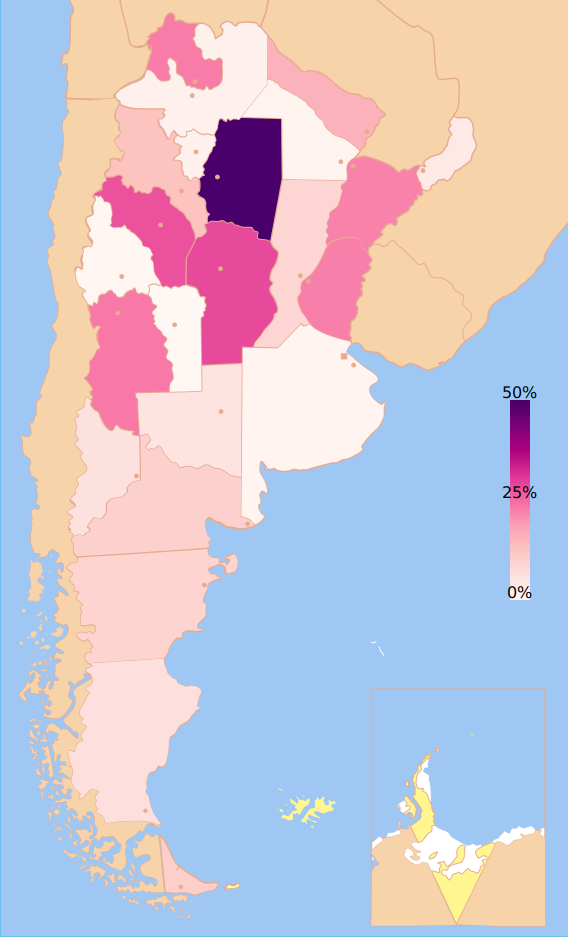

In [7]:
SVG("images/map_dominance.svg")

In [18]:
df_dominance

,winner,dominance,linear,color_hex
Cordoba,JUNTOS POR EL CAMBIO,0.290357,146,e7499b
Corrientes,ECO + VAMOS CORRIENTES,0.224055,112,f882aa
Salta,FRENTE DE TODOS,0.022228,8,fef1ed
Santa_Cruz,CAMBIA SANTA CRUZ,0.067354,32,fde0dd
Chaco,FRENTE DE TODOS,0.015762,5,fff3f0
Entre_Rios,JUNTOS POR ENTRE RÍOS,0.228799,114,f87fa9
Misiones,FRENTE JUNTOS POR EL CAMBIO,0.042922,19,fee9e6
Santa_Fe,JUNTOS POR EL CAMBIO,0.089294,43,fdd6d3
Ciudad_Autonoma_de_Buenos_Aires,JUNTOS POR EL CAMBIO,0.219084,109,f987ac
San_Juan,FRENTE DE TODOS - TODOS SAN JUAN,0.012394,3,fff5f1


## Amount of blank votes

In [8]:
dict_blank = {}

for district in districts:
    df_district = df_diputados.loc[df_diputados["Distrito"] == district]

    n_votes_positive = df_district.loc[df_district["tipoVoto"] == "positivo"]["votos"].sum()
    n_votes_blank = df_district.loc[df_district["tipoVoto"] == "blancos"]["votos"].sum()
    
    percentage_blank = n_votes_blank/(n_votes_positive + n_votes_blank)
    dict_blank[district] = percentage_blank
    
df_blank = pd.DataFrame({"blank":dict_blank})

In [16]:
# color_map_name = "RdPu"
color_map_name = "YlGn"
# color_map_name = "Greys"


# Append color column to dataframe
df_blank = appendLinearValues(df_blank, "blank")
df_blank = appendHexColors(df_blank, "linear", color_map_name)

# Create svg file
dict_min_max = createMinMaxDict(df_blank, "blank")
createFileSvgProvinces(df_blank, dict_min_max, color_map_name, "map_blank")

### Showcase

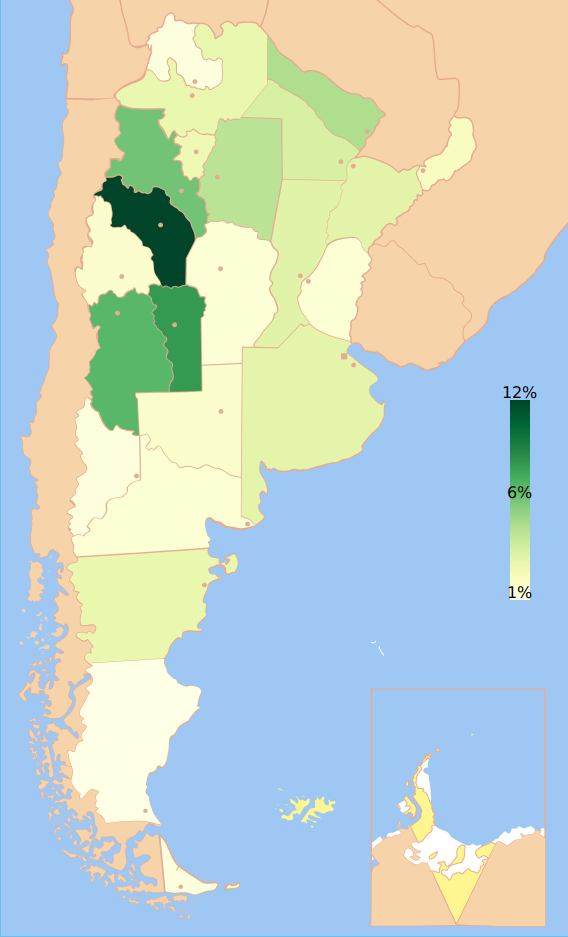

In [17]:
SVG("images/map_blank.svg")

In [18]:
df_blank

,blank,linear,color_hex
Buenos_Aires,0.031503,52,e4f4ab
Catamarca,0.064016,130,73c376
Chaco,0.036428,64,d8f0a3
Chubut,0.028857,46,eaf7af
Ciudad_Autonoma_de_Buenos_Aires,0.009559,0,ffffe5
Cordoba,0.014346,11,fcfed6
Corrientes,0.032143,53,e3f4aa
Entre_Rios,0.014600,12,fcfed4
Formosa,0.048613,93,b0de8f
Jujuy,0.012383,6,fdfedd


## Number of parties in each district

In [19]:
color_map_name = "RdPu"

dict_n_parties = {}

for district in districts:
    n_parties = df_votes_tot[district].astype(bool).sum(axis=0)
    dict_n_parties[district] = n_parties
    
df_n_parties = pd.DataFrame({"n_parties": dict_n_parties})

df_n_parties = appendHexColors(df_n_parties, "n_parties", color_map_name)

In [24]:
# Generate svg
x_bottom = 510
y_bottom = 600
width = 20
height = 20
color_map_name = "RdPu"

label_min = 0
label_max = 9
text_color = "#04758f"

text_discrete = createSvgDiscrete(x_bottom, y_bottom, width, height, color_map_name, label_min, label_max, text_color)

createFileSvgDiscrete(df_n_parties, text_discrete, color_map_name, "map_n_parties")

### Showcase

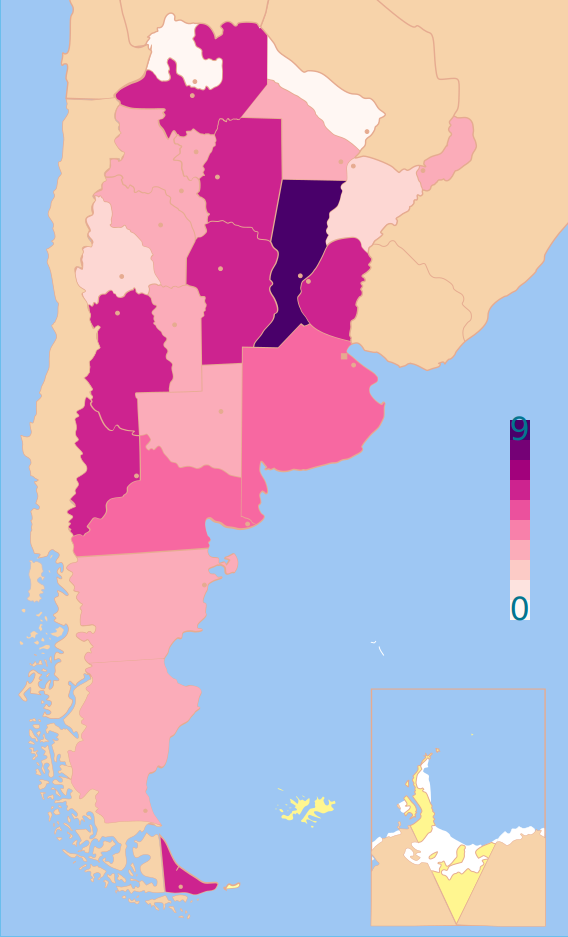

In [25]:
SVG("images/map_n_parties.svg")

In [26]:
df_n_parties

,n_parties,color_hex
Buenos_Aires,6,f768a1
Catamarca,5,fbacb9
Chaco,5,fbacb9
Chubut,5,fbacb9
Ciudad_Autonoma_de_Buenos_Aires,5,fbacb9
Cordoba,7,cd238f
Corrientes,4,fdd7d3
Entre_Rios,7,cd238f
Formosa,3,fff7f3
Jujuy,3,fff7f3


In [27]:
print(text_discrete)


    <rect x="510" y="600" width="20" height="20" fill="#fff7f3"/>
<rect x="510" y="580" width="20" height="20" fill="#fde3df"/>
<rect x="510" y="560" width="20" height="20" fill="#fccbc6"/>
<rect x="510" y="540" width="20" height="20" fill="#fbacb9"/>
<rect x="510" y="520" width="20" height="20" fill="#f880aa"/>
<rect x="510" y="500" width="20" height="20" fill="#eb519d"/>
<rect x="510" y="480" width="20" height="20" fill="#cd238f"/>
<rect x="510" y="460" width="20" height="20" fill="#a2017c"/>
<rect x="510" y="440" width="20" height="20" fill="#750176"/>
<rect x="510" y="420" width="20" height="20" fill="#49006a"/>
    /n<text x="520.0" y="620" width="10.0" height="20" text-anchor="middle" font-size="2em" fill="#04758f">
    0
    </text>
    <text x="520.0" y="440" width="10.0" height="20" text-anchor="middle" font-size="2em" fill="#04758f">
    9
    </text>


## Unique parties

In [28]:
dict_unique_parties = {}

for district in districts:
    dict_unique_parties[district] = []

for idx, row in df_votes_tot.iterrows():
    n_districts =  row.astype(bool).sum()
    
    if n_districts == 1:
        party = row.name
        
        district = row.idxmax()
        # print(f"{party}: {district}")
        
        dict_unique_parties[district].append(party)
        
dict_n_unique_parties = {}
for district in districts:
    n_unique_parties = len(dict_unique_parties[district])
    dict_n_unique_parties[district] = n_unique_parties
    
df_n_unique_parties = pd.DataFrame({"n_unique_parties": dict_n_unique_parties, "unique_parties": dict_unique_parties})

df_n_unique_parties = appendHexColors(df_n_unique_parties, "n_unique_parties", color_map_name)

In [29]:
# Generate svg
x_bottom = 510
y_bottom = 600
width = 20
height = 20
color_map_name = "RdPu"

label_min = df_n_unique_parties["n_unique_parties"].min()
label_max = df_n_unique_parties["n_unique_parties"].max()
text_color = "#04758f"

text_discrete = createSvgDiscrete(x_bottom, y_bottom, width, height, color_map_name, label_min, label_max, text_color)

createFileSvgDiscrete(df_n_unique_parties, text_discrete, color_map_name, "map_n_unique")

### Showcase

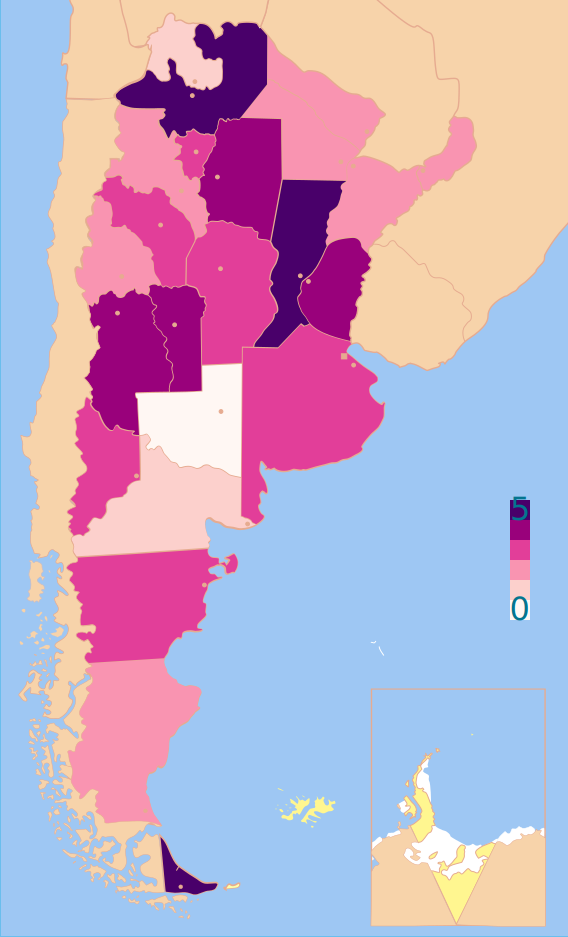

In [30]:
SVG("images/map_n_unique.svg")

In [39]:
df_n_unique_parties

,n_unique_parties,unique_parties,color_hex
Cordoba,3,"[HACEMOS POR CÓRDOBA, ENCUENTRO VECINAL CÓRDOB...",e23e99
Corrientes,2,"[ECO + VAMOS CORRIENTES, VAMOS CON VOS]",f994b1
Salta,5,"[JUNTOS POR EL CAMBIO +, UNIDOS POR SALTA, FRE...",49006a
Santa_Cruz,2,"[CAMBIA SANTA CRUZ, SOMOS ENERGÍA PARA RENOVAR...",f994b1
Chaco,2,"[CHACO CAMBIA + JUNTOS POR EL CAMBIO, FRENTE I...",f994b1
Entre_Rios,4,"[JUNTOS POR ENTRE RÍOS, CONSERVADOR POPULAR, N...",99017b
Misiones,2,"[FRENTE RENOVADOR DE LA CONCORDIA, LIBERTAD, V...",f994b1
Santa_Fe,5,"[FRENTE AMPLIO PROGRESISTA, SOMOS FUTURO, PODE...",49006a
Ciudad_Autonoma_de_Buenos_Aires,1,[AUTODETERMINACIÓN Y LIBERTAD],fcd0cc
San_Juan,2,"[FRENTE DE TODOS - TODOS SAN JUAN, CONSENSO IS...",f994b1


# Misc - examining dataset

## Which party won in each district

In [2]:
for district in districts:
    party_winning = df_votes_tot[district].idxmax()
    print(f"{district}: {party_winning:}")

Cordoba: JUNTOS POR EL CAMBIO
Corrientes: ECO + VAMOS CORRIENTES
Salta: FRENTE DE TODOS
Santa_Cruz: CAMBIA SANTA CRUZ
Chaco: FRENTE DE TODOS
Entre_Rios: JUNTOS POR ENTRE RÍOS
Misiones: FRENTE JUNTOS POR EL CAMBIO
Santa_Fe: JUNTOS POR EL CAMBIO
Ciudad_Autonoma_de_Buenos_Aires: JUNTOS POR EL CAMBIO
San_Juan: FRENTE DE TODOS - TODOS SAN JUAN
Tucuman: FRENTE DE TODOS
Buenos_Aires: JUNTOS
La_Pampa: JUNTOS POR EL CAMBIO
Neuquen: MOVIMIENTO POPULAR NEUQUINO
Rio_Negro: JUNTOS SOMOS RIO NEGRO
Tierra_del_Fuego,_Antartida_e_Islas_del_Atlantico_Sur: FRENTE DE TODOS
Jujuy: CAMBIA JUJUY
Mendoza: CAMBIA MENDOZA
Chubut: JUNTOS POR EL CAMBIO CHUBUT
La_Rioja: FRENTE DE TODOS
San_Luis: UNIDOS POR SAN LUIS
Catamarca: FRENTE DE TODOS
Santiago_del_Estero: FRENTE CIVICO POR SANTIAGO
Formosa: FRENTE DE TODOS
